In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from keras.models import load_model
from keras import backend as K
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, BatchNormalization, LSTM, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import plotly.graph_objects as go
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv("C:/Users/truon/Downloads/Waterlevel_Final.csv", parse_dates=['Time'], dayfirst=True)
# Quick look at the dataset
print(data.head())

# Basic statistics
print(data.describe())

fig = go.Figure()

# Actual water levels
fig.add_trace(go.Scatter(x=data['Time'], y=data['Waterlevel'],
                         mode='lines+markers',
                         name='Actual Waterlevel',
                         hovertemplate='Date: %{x}<br>Waterlevel: %{y}<extra></extra>'))

# Update layout
fig.update_layout(title='Waterlevel Forecast - CNN',
                  xaxis_title='Time',
                  yaxis_title='Waterlevel',
                  hovermode='x unified')
fig.show()

   Unnamed: 0                 Time  Waterlevel
0           0  2008-01-01 01:00:00       130.0
1           1  2008-01-01 04:00:00       121.0
2           2  2008-01-01 07:00:00       112.0
3           3  2008-01-01 10:00:00       113.5
4           4  2008-01-01 13:00:00       115.0
        Unnamed: 0    Waterlevel
count  29224.00000  29224.000000
mean   14611.50000    254.858738
std     8436.38647    154.476687
min        0.00000     10.000000
25%     7305.75000    150.000000
50%    14611.50000    213.000000
75%    21917.25000    318.000000
max    29223.00000   1042.000000


In [2]:
# Load the dataset
data = pd.read_csv(r"C:\Users\truon\Downloads\Waterlevel_Final.csv")
data['Time'] = pd.to_datetime(data['Time'])
data = data.drop('Unnamed: 0', axis=1)

# Use only the 'Waterlevel' column for raw data forecasting
water_levels = data[['Time', 'Waterlevel']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
water_levels['Scaled_Waterlevel'] = scaler.fit_transform(water_levels['Waterlevel'].values.reshape(-1, 1))

# Train-Val-Test split (70%, 10%, 20%)
train_size = int(len(water_levels) * 0.7)
val_size = int(len(water_levels) * 0.1)

train_data = water_levels.iloc[:train_size].copy()
val_data = water_levels.iloc[train_size:train_size + val_size].copy()
test_data = water_levels.iloc[train_size + val_size:].copy()

In [3]:
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

# Summary
print(f"Train data: {len(train_data)} entries")
print(f"Validation data: {len(val_data)} entries")
print(f"Test data: {len(test_data)} entries")

# Check the structure of the resulting datasets
train_data.head(), val_data.head(), test_data.head()

Train data: 20456 entries
Validation data: 2922 entries
Test data: 5846 entries


(                 Time  Waterlevel  Scaled_Waterlevel
 0 2008-01-01 01:00:00       130.0           0.116279
 1 2008-01-01 04:00:00       121.0           0.107558
 2 2008-01-01 07:00:00       112.0           0.098837
 3 2008-01-01 10:00:00       113.5           0.100291
 4 2008-01-01 13:00:00       115.0           0.101744,
                  Time  Waterlevel  Scaled_Waterlevel
 0 2015-01-01 01:00:00        62.0           0.050388
 1 2015-01-01 04:00:00        76.0           0.063953
 2 2015-01-01 07:00:00        90.0           0.077519
 3 2015-01-01 10:00:00        98.0           0.085271
 4 2015-01-01 13:00:00       106.0           0.093023,
                  Time  Waterlevel  Scaled_Waterlevel
 0 2016-01-01 07:00:00        72.0           0.060078
 1 2016-01-01 10:00:00        98.0           0.085271
 2 2016-01-01 13:00:00       124.0           0.110465
 3 2016-01-01 16:00:00       113.0           0.099806
 4 2016-01-01 19:00:00       102.0           0.089147)

In [4]:
# Prepare input/output for CNN
def create_dataset(data, look_back=5):
    X, y = [], []
    scaled_data = data['Scaled_Waterlevel'].values  # Use the scaled water level data
    for i in range(len(scaled_data) - look_back):
        X.append(scaled_data[i:i + look_back])
        y.append(scaled_data[i + look_back])
    return np.array(X), np.array(y)

look_back = 240 # Use the last 5 water levels to predict the next one

# Create training, validation, and test datasets
X_train, y_train = create_dataset(train_data, look_back)
X_val, y_val = create_dataset(val_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# Reshape the data for Conv1D (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], look_back, 1))
X_val = X_val.reshape((X_val.shape[0], look_back, 1))
X_test = X_test.reshape((X_test.shape[0], look_back, 1))


In [5]:
# Check the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (20216, 240, 1), y_train shape: (20216,)
X_val shape: (2682, 240, 1), y_val shape: (2682,)
X_test shape: (5606, 240, 1), y_test shape: (5606,)


In [16]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=2, padding='same', activation='relu', input_shape=(look_back, 1)))
model.add(Conv1D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=256, kernel_size=8, padding='same', activation='relu'))
model.add(Conv1D(filters=256, kernel_size=8, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))


model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


In [18]:
model = load_model('best_model(240,128)_CNN2.h5')

In [19]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 240, 128)          384       
                                                                 
 conv1d_21 (Conv1D)          (None, 240, 128)          32896     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 120, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_22 (Conv1D)          (None, 120, 256)          262400    
                                                                 
 conv1d_23 (Conv1D)          (None, 120, 256)          524544    
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 60, 256)          0         
 g1D)                                                 

In [17]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 240, 128)          384       
                                                                 
 conv1d_17 (Conv1D)          (None, 240, 128)          32896     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 120, 128)         0         
 1D)                                                             
                                                                 
 conv1d_18 (Conv1D)          (None, 120, 256)          262400    
                                                                 
 conv1d_19 (Conv1D)          (None, 120, 256)          524544    
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 60, 256)          0         
 1D)                                                  

In [177]:
# Early stopping to prevent overfitting
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_model({},{})_CNN3.h5'.format(look_back,128), monitor='val_loss', save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10, min_lr=0.00001)

# Train the model using GPU
with tf.device('/GPU:0'):
    history = model.fit(
        X_train, 
        y_train, 
        validation_data=(X_val, y_val), 
        epochs=100, 
        batch_size=128, 
        verbose=1,
        callbacks=[early_stopping,reduce_lr,checkpoint]
    )

Epoch 1/100
158/158 [==============================] - 9s 48ms/step - loss: 0.0229 - val_loss: 1.9608e-04 - lr: 0.0010
Epoch 2/100
158/158 [==============================] - 7s 47ms/step - loss: 7.9797e-04 - val_loss: 1.4338e-04 - lr: 0.0010
Epoch 3/100
158/158 [==============================] - 7s 46ms/step - loss: 6.0833e-04 - val_loss: 1.2637e-04 - lr: 0.0010
Epoch 4/100
158/158 [==============================] - 7s 45ms/step - loss: 5.4092e-04 - val_loss: 1.5695e-04 - lr: 0.0010
Epoch 5/100
158/158 [==============================] - 7s 47ms/step - loss: 5.1278e-04 - val_loss: 4.9454e-05 - lr: 0.0010
Epoch 6/100
158/158 [==============================] - 7s 45ms/step - loss: 4.4695e-04 - val_loss: 9.1082e-05 - lr: 0.0010
Epoch 7/100
158/158 [==============================] - 7s 45ms/step - loss: 4.2714e-04 - val_loss: 9.8735e-05 - lr: 0.0010
Epoch 8/100
158/158 [==============================] - 7s 45ms/step - loss: 3.8415e-04 - val_loss: 1.0542e-04 - lr: 0.0010
Epoch 9/100
158/158 

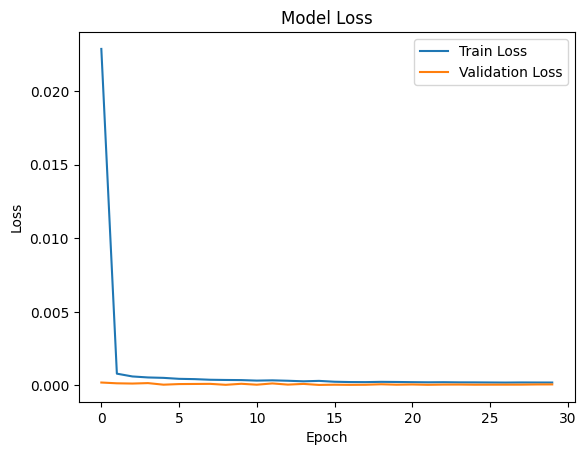

In [178]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [6]:
def forecast_with_cnn(model, X_test, look_back, scaler, test, start_date, end_date):
    test_index = test.index

    # Find the indices for the specified start and end dates
    start_idx = test_index.get_loc(test_index[test_index >= pd.to_datetime(start_date)].min())
    end_idx = test_index.get_loc(test_index[test_index <= pd.to_datetime(end_date)].max())

    input_sequence = X_test[start_idx].reshape(1, look_back, 1)  # Ensure it is 3D for Conv1D input
    predictions = []

    for i in range(start_idx, end_idx + 1):
        # Make a prediction
        pred = model.predict(input_sequence)

        # Append the prediction to the list of predictions
        predictions.append(pred[0, 0])

        # Update the input sequence: remove the oldest value and add the latest prediction
        pred_reshaped = np.array([[pred[0, 0]]]).reshape(1, 1, 1)  # Reshape to (1, 1, 1)
        input_sequence = np.append(input_sequence[:, 1:, :], pred_reshaped, axis=1)

    # Inverse transform the predictions back to the original scale
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    return predictions, start_idx, end_idx


In [7]:
testdate = [['2016-01-01 07:00:00','2016-01-06 07:00:00'],['2016-03-01 07:00:00','2016-03-06 07:00:00'],
            ['2016-05-01 07:00:00','2016-05-06 07:00:00'],['2016-07-01 07:00:00','2016-07-06 07:00:00'],
            ['2016-10-01 07:00:00','2016-10-06 07:00:00'],['2017-01-01 07:00:00','2017-01-06 07:00:00'],
            ['2017-03-01 07:00:00','2017-03-06 07:00:00'],['2017-05-01 07:00:00','2017-05-06 07:00:00'],
            ['2017-07-01 07:00:00','2017-07-06 07:00:00'],['2017-10-01 07:00:00','2017-10-06 07:00:00']]

In [4]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_68 (Conv1D)          (None, 240, 128)          384       
                                                                 
 conv1d_69 (Conv1D)          (None, 240, 128)          32896     
                                                                 
 max_pooling1d_34 (MaxPoolin  (None, 120, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_70 (Conv1D)          (None, 120, 256)          262400    
                                                                 
 conv1d_71 (Conv1D)          (None, 120, 256)          524544    
                                                                 
 max_pooling1d_35 (MaxPoolin  (None, 60, 256)          0         
 g1D)                                                

In [8]:
test = data[train_size+val_size:]

In [9]:
test = test.set_index('Time')

In [10]:
if not isinstance(test.index, pd.DatetimeIndex):
    test.index = pd.to_datetime(test.index)


In [22]:
model = load_model(r"C:\Users\truon\Downloads\final_cnn+conformer_model.h5",compile=False)

ValueError: Unrecognized keyword arguments: ['batch_shape']

In [14]:
sum_rmse = 0
sum_mae = 0
for i in testdate:# Define the start and end date for forecasting (adjust as needed)
    start_date,end_date = i
    print(start_date,end_date)
    if test.index.min() <= pd.to_datetime(start_date) <= test.index.max() and test.index.min() <= pd.to_datetime(end_date) <= test.index.max():
        # Make forecasts using the CNN model for the specified date range
        cnn_forecast, start_idx, end_idx = forecast_with_cnn(model, X_test, look_back, scaler, test, start_date, end_date)

        # Inverse transform the true test values back to the original scale for the same range
        y_test_actual = scaler.inverse_transform(y_test[start_idx:end_idx+1].reshape(-1, 1))

        # Get the corresponding dates
        forecast_dates = test.index[start_idx:end_idx+1]

        # Calculate performance metrics for the forecast in this range
        mae = mean_absolute_error(y_test_actual, cnn_forecast)
        rmse = mean_squared_error(y_test_actual, cnn_forecast)

        # Output the performance metrics
        print(f"Forecasting from {start_date} to {end_date}")
        print(f"MAE: {mae}")
        print(f"RMSE: {rmse}")
    else:
        print("The start date or end date is out of range in the test set.")
    fig = go.Figure()
    sum_mae = sum_mae+mae
    sum_rmse = sum_rmse+rmse
    # Actual water levels
    fig.add_trace(go.Scatter(x=test.index, y=y_test_actual.flatten(),
                            mode='lines+markers',
                            name='Actual Waterlevel',
                            hovertemplate='Date: %{x}<br>Waterlevel: %{y}<extra></extra>'))

    # CNN forecasted water levels
    fig.add_trace(go.Scatter(x=test.index, y=cnn_forecast.flatten(),
                            mode='lines+markers',
                            name='CNN Forecast',
                            hovertemplate='Date: %{x}<br>Waterlevel: %{y}<extra></extra>'))

    # Update layout
    fig.update_layout(title='Waterlevel Forecast - CNN',
                    xaxis_title='Time',
                    yaxis_title='Waterlevel',
                    hovermode='x unified')
    fig.show()
print("Average MAE on 10 test point:", sum_mae/10)
print("Average RMSE on 10 test point:", sum_rmse/10)

2016-01-01 07:00:00 2016-01-06 07:00:00
1/1 [==============================] - 0s 21ms/step
Forecasting from 2016-01-01 07:00:00 to 2016-01-06 07:00:00
MAE: 20.851792312249906
RMSE: 751.4135149030977


2016-03-01 07:00:00 2016-03-06 07:00:00
1/1 [==============================] - 0s 33ms/step
Forecasting from 2016-03-01 07:00:00 to 2016-03-06 07:00:00
MAE: 4.139918257550495
RMSE: 30.035277969402646


2016-05-01 07:00:00 2016-05-06 07:00:00
1/1 [==============================] - 0s 21ms/step
Forecasting from 2016-05-01 07:00:00 to 2016-05-06 07:00:00
MAE: 7.8041225526391
RMSE: 84.79279791961265


2016-07-01 07:00:00 2016-07-06 07:00:00
1/1 [==============================] - 0s 21ms/step
Forecasting from 2016-07-01 07:00:00 to 2016-07-06 07:00:00
MAE: 27.245157381383382
RMSE: 873.2857601077001


2016-10-01 07:00:00 2016-10-06 07:00:00
1/1 [==============================] - 0s 21ms/step
Forecasting from 2016-10-01 07:00:00 to 2016-10-06 07:00:00
MAE: 21.175175550507337
RMSE: 576.003572335065


2017-01-01 07:00:00 2017-01-06 07:00:00
1/1 [==============================] - 0s 25ms/step
Forecasting from 2017-01-01 07:00:00 to 2017-01-06 07:00:00
MAE: 21.542854122999238
RMSE: 650.6785805112592


2017-03-01 07:00:00 2017-03-06 07:00:00
1/1 [==============================] - 0s 22ms/step
Forecasting from 2017-03-01 07:00:00 to 2017-03-06 07:00:00
MAE: 17.828329132824408
RMSE: 403.4326849501231


2017-05-01 07:00:00 2017-05-06 07:00:00
1/1 [==============================] - 0s 21ms/step
Forecasting from 2017-05-01 07:00:00 to 2017-05-06 07:00:00
MAE: 20.20507700850324
RMSE: 604.8046967638145


2017-07-01 07:00:00 2017-07-06 07:00:00
1/1 [==============================] - 0s 20ms/step
Forecasting from 2017-07-01 07:00:00 to 2017-07-06 07:00:00
MAE: 17.541954226610137
RMSE: 422.2957211281968


2017-10-01 07:00:00 2017-10-06 07:00:00
1/1 [==============================] - 0s 20ms/step
Forecasting from 2017-10-01 07:00:00 to 2017-10-06 07:00:00
MAE: 82.99703439852087
RMSE: 7665.310221604297


Average MAE on 10 test point: 24.133141494378812
Average RMSE on 10 test point: 1206.2052828192568


In [20]:
start_date = '2016-01-01 07:00:00'
end_date = '2016-06-01 07:00:00'
print(start_date,end_date)
if test.index.min() <= pd.to_datetime(start_date) <= test.index.max() and test.index.min() <= pd.to_datetime(end_date) <= test.index.max():
    # Make forecasts using the CNN model for the specified date range
    cnn_forecast, start_idx, end_idx = forecast_with_cnn(model, X_test, look_back, scaler, test, start_date, end_date)

    # Inverse transform the true test values back to the original scale for the same range
    y_test_actual = scaler.inverse_transform(y_test[start_idx:end_idx+1].reshape(-1, 1))

    # Get the corresponding dates
    forecast_dates = test.index[start_idx:end_idx+1]

    # Calculate performance metrics for the forecast in this range
    mae = mean_absolute_error(y_test_actual, cnn_forecast)
    rmse = mean_squared_error(y_test_actual, cnn_forecast)

    # Output the performance metrics
    print(f"Forecasting from {start_date} to {end_date}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
else:
    print("The start date or end date is out of range in the test set.")
fig = go.Figure()
sum_mae = sum_mae+mae
sum_rmse = sum_rmse+rmse
# Actual water levels
fig.add_trace(go.Scatter(x=test.index, y=y_test_actual.flatten(),
                        mode='lines+markers',
                        name='Actual Waterlevel',
                        hovertemplate='Date: %{x}<br>Waterlevel: %{y}<extra></extra>'))

# CNN forecasted water levels
fig.add_trace(go.Scatter(x=test.index, y=cnn_forecast.flatten(),
                        mode='lines+markers',
                        name='CNN Forecast',
                        hovertemplate='Date: %{x}<br>Waterlevel: %{y}<extra></extra>'))

# Update layout
fig.update_layout(title='Waterlevel Forecast - CNN',
                xaxis_title='Time',
                yaxis_title='Waterlevel',
                hovermode='x unified')
fig.show()

2016-01-01 07:00:00 2016-06-01 07:00:00
1/1 [==============================] - 0s 20ms/step
Forecasting from 2016-01-01 07:00:00 to 2016-06-01 07:00:00
MAE: 157.2126515810864
RMSE: 30188.50704769244


In [247]:
fig = go.Figure()

# Actual water levels
fig.add_trace(go.Scatter(x=test.index, y=y_test_actual.flatten(),
                         mode='lines+markers',
                         name='Actual Waterlevel',
                         hovertemplate='Date: %{x}<br>Waterlevel: %{y}<extra></extra>'))

# CNN forecasted water levels
fig.add_trace(go.Scatter(x=test.index, y=cnn_forecast.flatten(),
                         mode='lines+markers',
                         name='CNN Forecast',
                         hovertemplate='Date: %{x}<br>Waterlevel: %{y}<extra></extra>'))

# Update layout
fig.update_layout(title='Waterlevel Forecast - CNN',
                  xaxis_title='Time',
                  yaxis_title='Waterlevel',
                  hovermode='x unified')
fig.show()